# Loan Default Prediction Report
---
**Author:** Tyler Chang | **Current Version Release Date:** September 30, 2023 | [GitHub]('https://github.com/Habeus-Crimpus') | [LinkedIn]('https://www.linkedin.com/in/tylerchang/') | [Data Portfolio]('https://troopl.com/tchang343w')

## Table of Contents
- [Report Summary](#heading-2)
- [Preparing the Data](#heading-2)
- [Exploring the Dataset](#heading-2)
- [Modeling the Data](#heading-2)

<a name="Heading-2"></a>
## Report Summary

Based on the [Coursera loan default prediction challenge](https://www.coursera.org/projects/data-science-coding-challenge-loan-default-prediction#details) and using data publicly available [here](https://www.kaggle.com/datasets/nikhil1e9/loan-default), this report covers the importing, cleaning, analysis, visualization, and ultimate modeling of over 250k rows of loan taker data to predict whether a given loan will ultimately default. This version of the report (version 1) culminates in two models with over 92% accuracy and similarly high performance across other metrics.

### Report Highlights

* Approximately 11.6% of the loans in the dataset defaulted.
* The average loan is approximately 2.18x that of the loan taker's income.
* The baseline accuracy is approximately 88.4%.
* XGBoosting and Random Forest models perform best across multiple metrics of classification success, beating the baseline accuracy by up to 5%.
* Model evaluation is best based on f1-scores here since both recall and precision would be of interest to a business and
to consumers.

<a name="header-2"></a>
## Preparing the Data

This section covers the importing of all required Python libraries, the data itself, and the process of cleaning the data.

### Loading the Required Libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# machine learning 
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# miscellaneous
from IPython import display
from pandasql import sqldf
import joblib

### Importing the Dataset

In [2]:
df = pd.read_csv('Loan_default.csv')

### Cleaning the Dataset

As a first step, let's look at the first five rows of the table so that we understand what types of information is available.

In [3]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


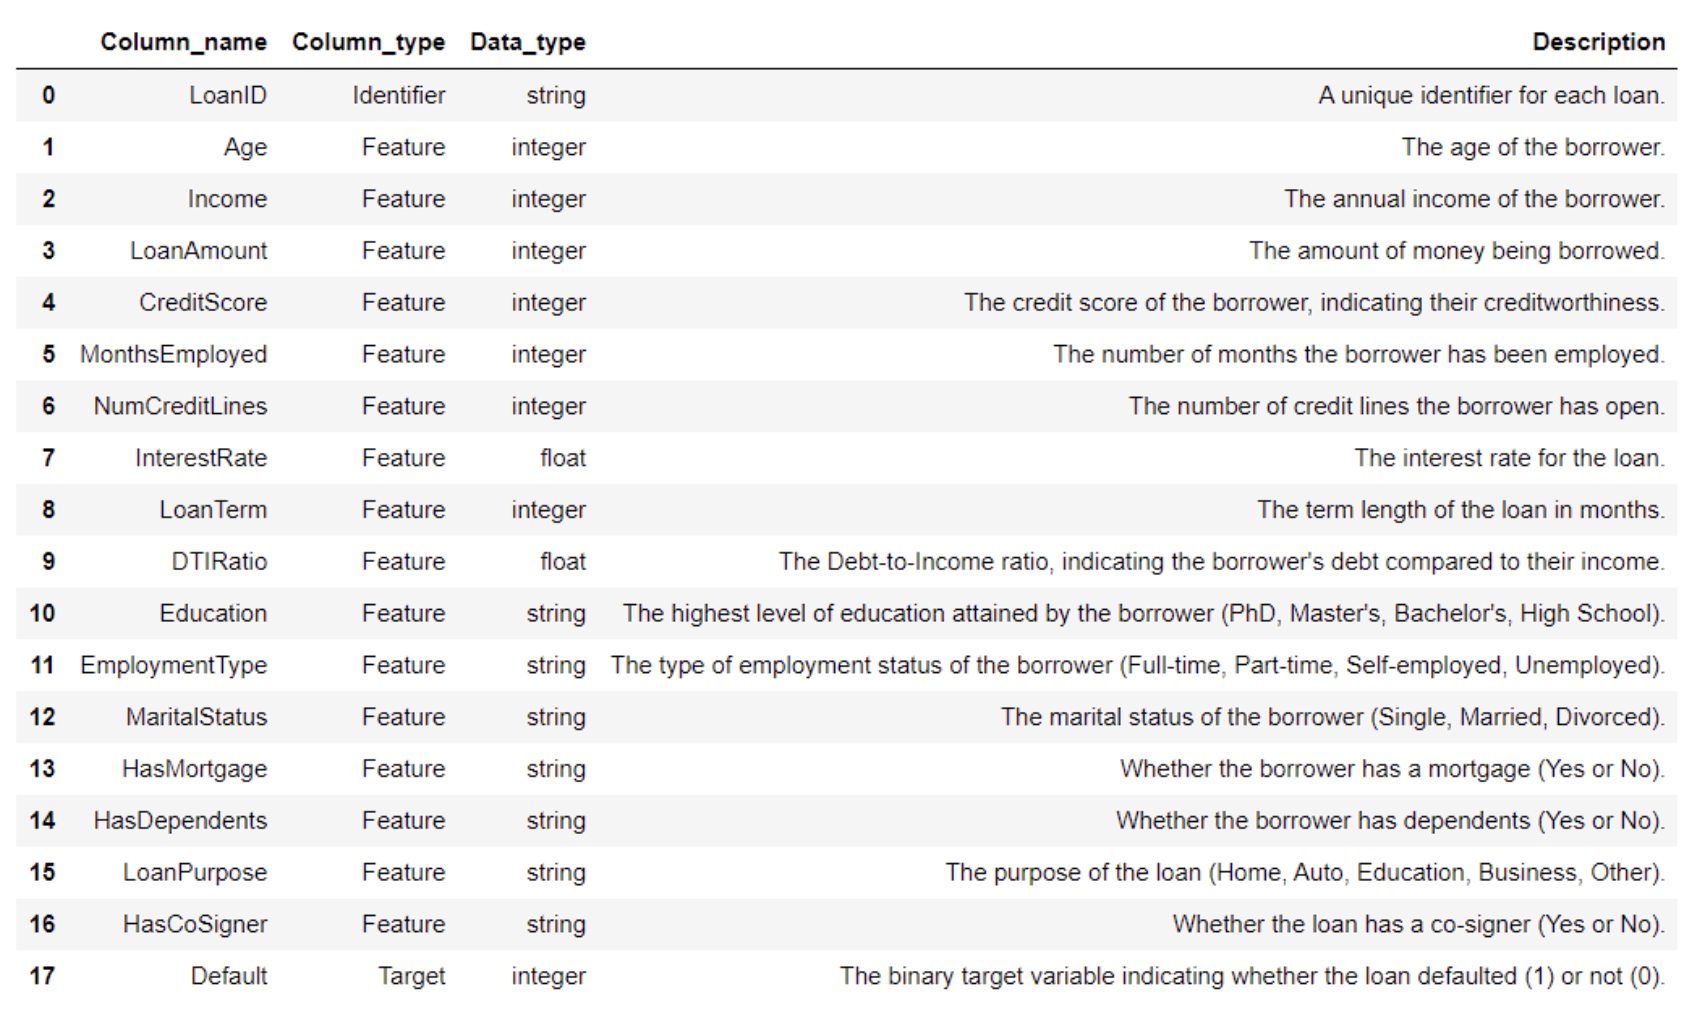

In [4]:
display.Image('Column_Descriptions.png')

The **Default** column is what we want to predict. Importantly, it contains only two possible values, 1 and 0, representing that a loan defaulted and that it did not, respectively. Since several of the columns are non-numeric, they will need to be encoded numerically before they can be used to make models. For now, however, it is more readable if they are left as text. 

Before proceeding on, a check for missing values must be done.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

All of the columns have 255,347 non-null values, meaning that there are no missing values. This does not mean that all the values are valid. In particular, none of the numeric columns (those marked as **int64** or **float64** in the table above) should have any negative values. To confirm this, we can look at the numeric summary table below.

In [6]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


By looking at the *min* row, we see that none of the columns contain negative values. 

All of the values seem appropriate for their respective subjects, meaning that the data is now ready for analysis.

<a name="heading-2"></a>
## Exploring the Dataset

We see from the above table that the average age of a loan taker is approximately 43 years old with the dataset including borrowers ranging from 18 to 69 years old. This age range is to be expected since most loan providers do not offer loans to minors and many seniors have already acquired the sorts of items (homes, education, cars, etc.) for which loans are most often taken.

It is still important to check that we do not have an imbalance in the ages represented by the data. To check this, we can plot the distribution of the frequency of the ages.

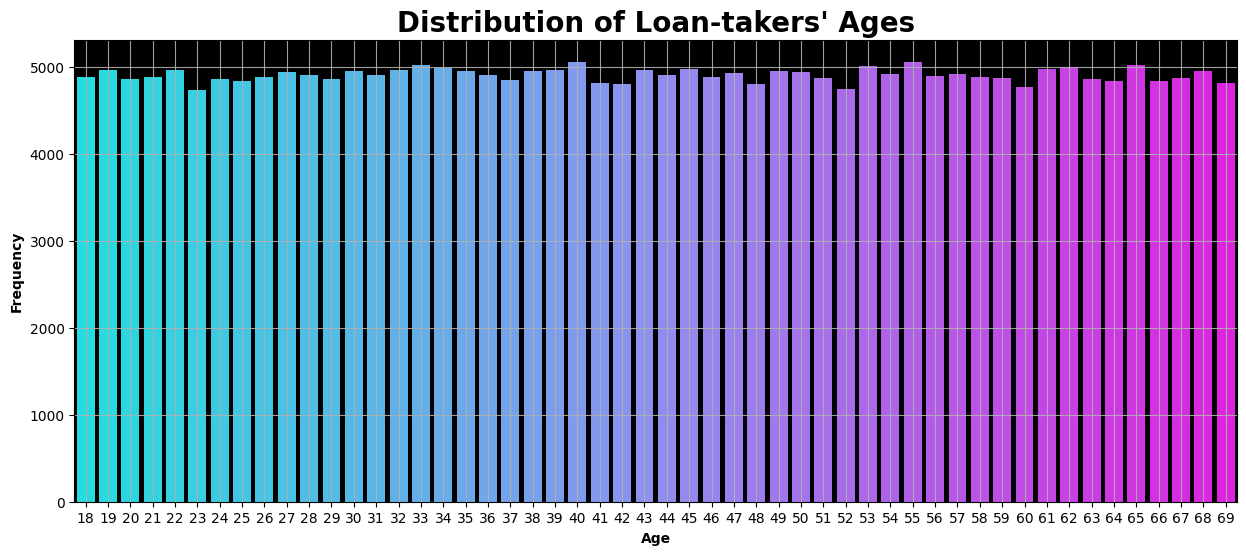

In [7]:
# counting the number of loan-taker for each age + sorting by age (ascending)
age_counts = pd.DataFrame(df.Age.value_counts().sort_index()).reset_index()
age_counts.columns = ['Age', 'Count']

# making the chart
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = 'Age', y = 'Count', data = age_counts, palette = 'cool')
plt.xlabel('Age', weight = 'bold', size = 10)
plt.ylabel('Frequency', weight = 'bold', size = 10)
plt.title("Distribution of Loan-takers' Ages", weight = 'bold', size = 20)
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()

There are similar numbers of persons included in the dataset for each age. As a result, we can safely assume that any finding of later models or analysis are not primarily a result of an imbalance in the ages represented in the data.

It is also worthwhile to look at the distributions of the incomes and size of the loans taken, which can be accomplished with the following chart.

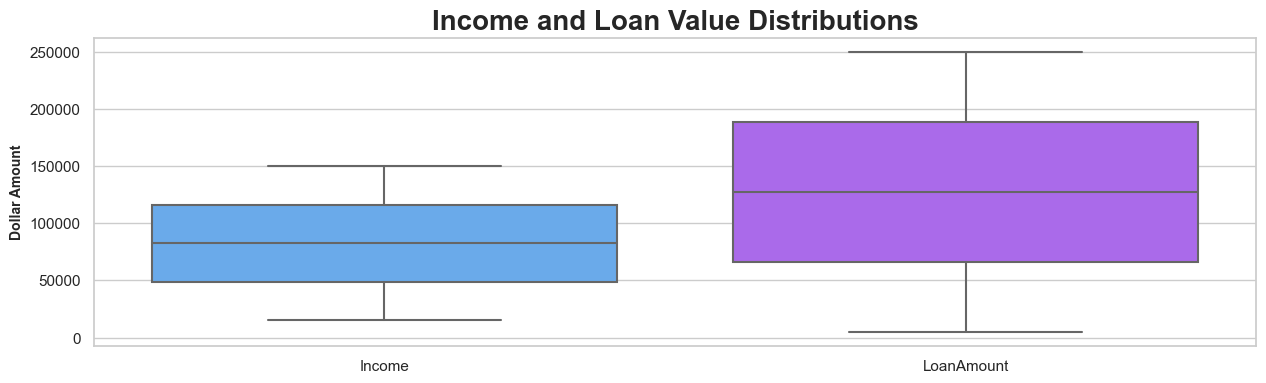

In [8]:
plt.figure(figsize=(15, 4))
sns.set(style = 'whitegrid')
sns.boxplot(df[['Income', 'LoanAmount']], palette='cool')
plt.ylabel('Dollar Amount', weight = 'bold', size = 10)
plt.title('Income and Loan Value Distributions', weight = 'bold', size = 20)
plt.show()

There are no outlier values for either income or loan amount. This alone does not allow us to say too much about the overall dataset by itself but it does allow us to continue without worrying about an unusually large value skewing later results.

The incomes range from 15k to approximately 150k and the loan amounts range from 5k up to 249k. The majority of loan takers
had an income under 116k, which is lower than the average loan of 127.5k. This shows that the average loan is substantially larger than the average income but to better understand the relationship between the two measurements, we have to look at the difference between income and loan amount by loan taker.

In [9]:
# Calculating the net differnece between income and loan amount AND
# the percentage of a person's income that the loan represents.
'''
Note: The incLoanPerDiff (income loan percentage difference) is in terms of percent, meaning
that a value of 246.7 means that the loan is 246.7% of the loan takers income. 

The incLoanNetDiff is measuring the raw difference between a person's income and the loan
value. If the list value is positive, the person took a loan that is smaller than their 
income and if the value is negative, the loan is larger than the income.
''' 
incLoanNetDiff = []
incLoanPerDiff = []
for i in range(df.shape[0]):
    incLoanNetDiff.append(df.Income[i] - df.LoanAmount[i])
    incLoanPerDiff.append((df.LoanAmount[i] / df.Income[i])*100)    
    
# adding the new lists to the table
df['IncLoanNetDiff'] = incLoanNetDiff
df['IncLoanPerDiff'] = incLoanPerDiff

# displaying the numeric summary of the two new columns
df[['IncLoanNetDiff', 'IncLoanPerDiff']].describe()

,IncLoanNetDiff,IncLoanPerDiff
count,255347.000000,255347.000000
mean,-45079.560915,217.747982
std,80878.297292,217.835733
min,-234492.000000,3.374929
25%,-106751.000000,80.362790
50%,-44996.000000,154.672013
75%,16325.500000,267.174408
max,144721.000000,1653.245976


The average loan is approximately 45,079 greater than the loan taker's income and the loans total value represents approximatley 217.7% of their income. This is somewhat differently represented by the median loan-income difference
at 44,996 and the median percentage of income represented at approximately 154.7%. This implies that those taking 
loans larger than the median value are larger by a greater magnitude than those who take smaller loans are smaller. 

This is shown by the following two charts:

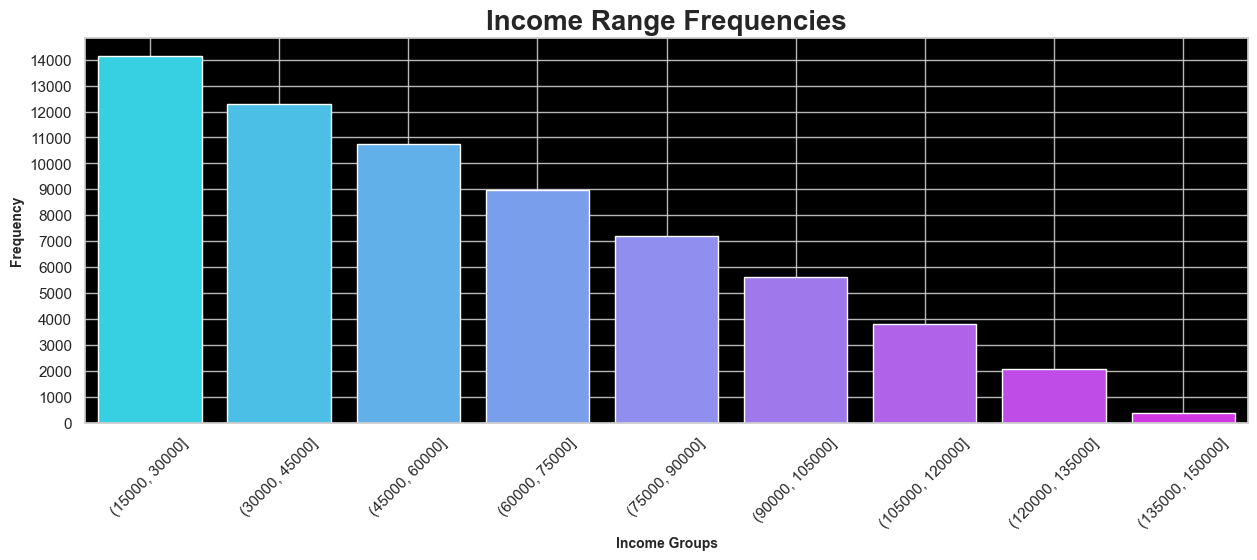

In [10]:
# defining bin edges for the IncLoanNetDiff column
diff_bin_edges = range(15000, 160000, 15000)

# making bins
df['IncLoanDiff_bins'] = pd.cut(df['IncLoanNetDiff'], bins = diff_bin_edges)

# Counting the frequency in each bin
income_counts = df.IncLoanDiff_bins.value_counts().reset_index()
income_counts.columns = ['Income Value', 'Count']

# plotting the IncLoanNetDiff frequency counts
plt.figure(figsize = (15, 5))
sns.set(style = 'whitegrid')
ax = sns.barplot(x = 'Income Value', y = 'Count', data = income_counts, palette = 'cool')
plt.xlabel('Income Groups', weight = 'bold', size = 10)
plt.ylabel('Frequency', weight = 'bold', size = 10)
plt.title('Income Range Frequencies', weight = 'bold', size =20)
plt.xticks(rotation = 45)
plt.yticks(list(range(0, 15000, 1000)))
ax.set_facecolor('black')
#for spine in ax.spines.values():
#    spine.set_visible(False)
plt.grid(alpha = 0.9)
plt.show()

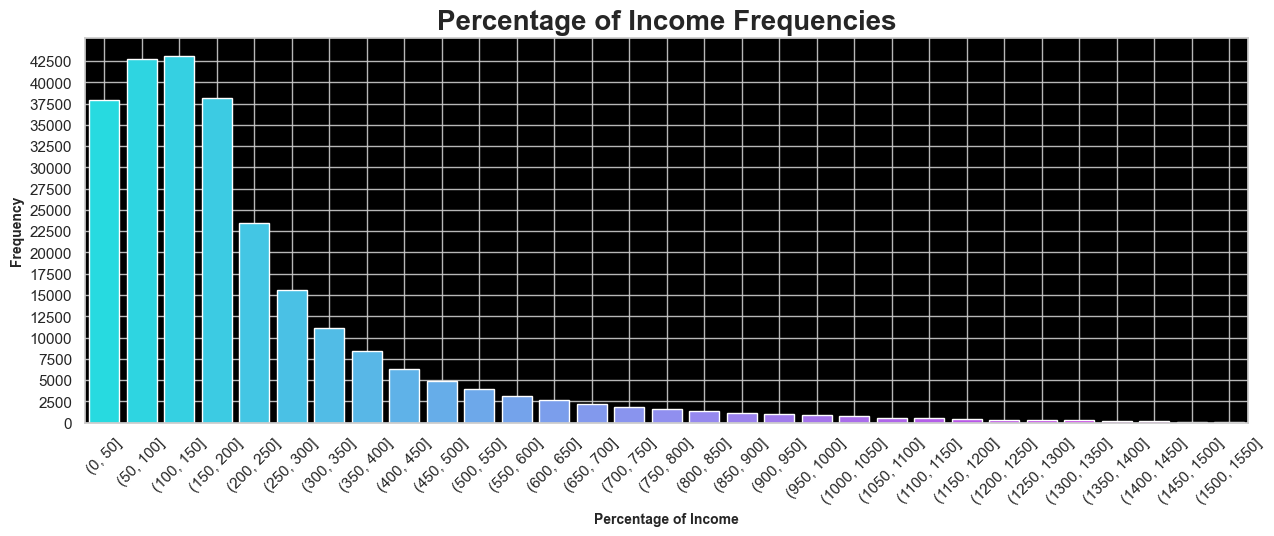

In [11]:
# defining bin edges for the IncLoanPerDiff column
per_bin_edges = range(0, 1600, 50)

# making bins
df['IncLoanPer_bins'] = pd.cut(df['IncLoanPerDiff'], bins = per_bin_edges)

# Counting the frequency in each bin
per_counts = df.IncLoanPer_bins.value_counts().reset_index()
per_counts.columns = ['Percentage Value', 'Count']

# plotting the IncLoanNetDiff frequency counts
plt.figure(figsize = (15, 5))
sns.set(style = 'whitegrid')
ax = sns.barplot(x = 'Percentage Value', y = 'Count', data = per_counts, palette = 'cool')
plt.xlabel('Percentage of Income', weight = 'bold', size = 10)
plt.ylabel('Frequency', weight = 'bold', size = 10)
plt.title('Percentage of Income Frequencies', weight = 'bold', size =20)
plt.xticks(rotation = 45)
plt.yticks(list(range(0, 45000, 2500)))
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()

The **Income Range Frequecies** chart is very positively skewed with a consistently declining frequency as you go up in 
income group. This is somewhat expected since the most common reasons for taking loans--education, housing, healthcare, cars--become less prohibitively expensive without loan assistance as your income goes up. 

The **Percentage of Income Frequencies** chart is also positively skewed with the largest groups being those borrowing between
50-100% and 100-150% of their income's value. There is a significant drop-off in loan takers after the percentage of income being borrowed exceeds 350% and this downward trend continues consistently for the rest of the percentage ranges. 

We can improve our understanding of the relationship between income and loan amount by plotting the relationship directly:

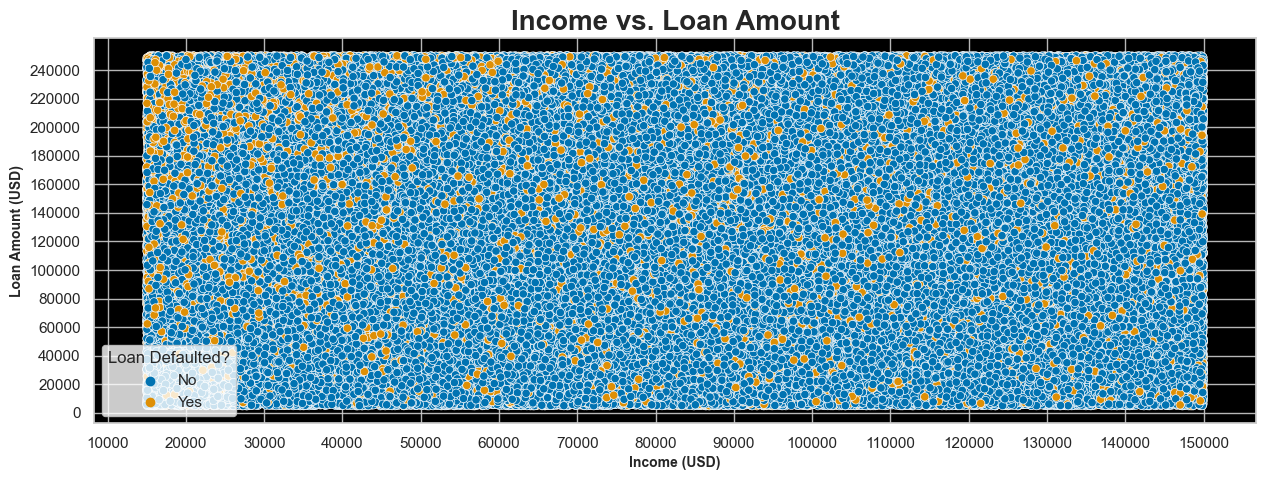

In [12]:
# adding a column to the table for coloring purposes
df['Default_word_ver'] = ['Yes' if val == 1 else 'No' for val in df.Default]

# plotting the incomes against their associated loan amounts
plt.figure(figsize = (15, 5))
ax = sns.scatterplot(data = df, x = 'Income', y = 'LoanAmount', hue = 'Default_word_ver', palette='colorblind')
plt.legend(loc = 'lower left', title = 'Loan Defaulted?')
plt.xlabel('Income (USD)', weight = 'bold', size = 10)
plt.ylabel('Loan Amount (USD)', weight = 'bold', size = 10)
plt.title('Income vs. Loan Amount', weight = 'bold', size = 20)
plt.yticks(list(range(0,260000,20000)))
plt.xticks(list(range(10000,160000,10000)))
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()

From this chart, we can see a few key findings:
* The vast majority of loans do not default.
* There is no apparent correlation between income level and loan amount. 
* There are more loans that default on the lower end of icomes but there are defaulting loans throughout the entire range.

To make this more precise, we can visualize the default-to-no-default ratio as a pie chart.

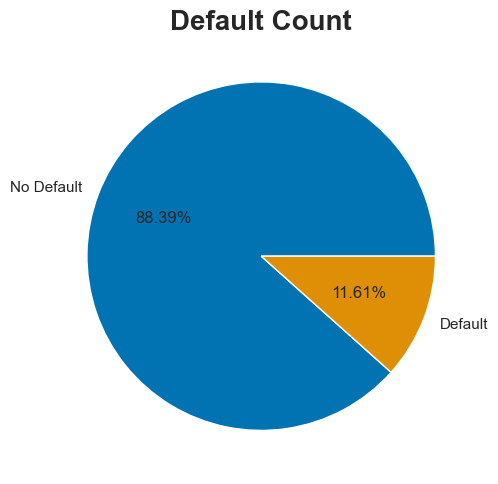

In [13]:
# counting the number of defaults/no defaults and the percentages they make up.
default_df = pd.DataFrame({'Category': ['No Default', 'Default'],
                           'Count': [df[df['Default']==0].count()['Default'],
                                     df[df['Default']==1].count()['Default']]})

# creating the data for the charts
count_data = [val for val in default_df.Count]

# making the pie chart
labels = ['No Default', 'Default']
palette_color = sns.color_palette('colorblind')
plt.figure(figsize=(15, 5))
plt.pie(count_data, labels = labels, colors = palette_color, autopct = '%1.2f%%')
plt.title('Default Count', fontsize = 20, fontweight = 'bold')
plt.tight_layout()
plt.show()

In [14]:
# Displaying the actual number in each of the above categories
default_df

,Category,Count
0,No Default,225694
1,Default,29653


There are 225,694 loans that did not default, accounting for approximately 88.39% of the borrowers, and 29,653 loans that
did default, making up the remaining 11.61%. So, while there are a large number of defaulting loans, they are far from being
the majority. As will be shown later, this imbalance in classes does have a significant effect on model performance and will 
be adjusted for later on.

Now, while income does affect the size of a loan that is accessible to a person, their credit score also tends to affect their eligibility. To start examining the effect this has on the loans, let's first look at the how many people have a given credit score.

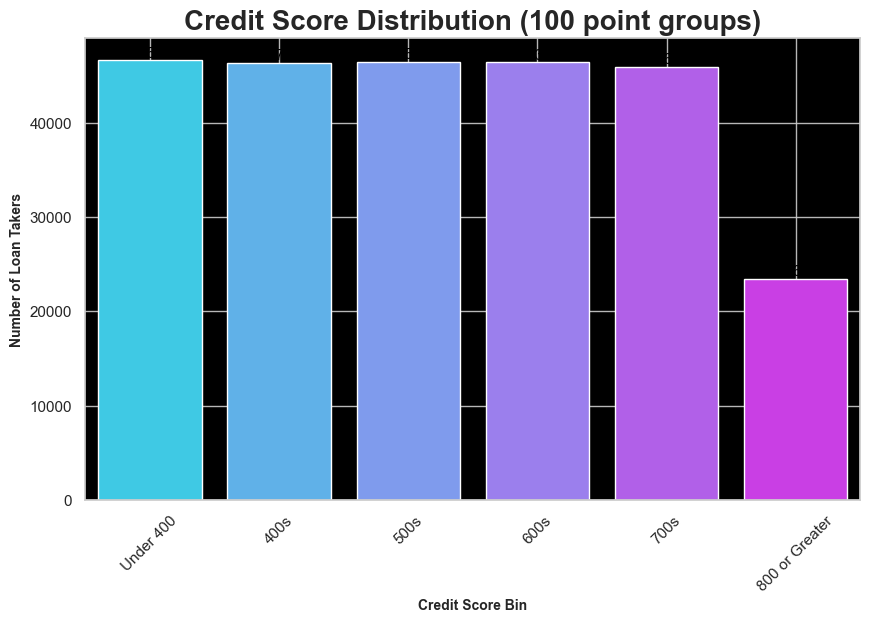

In [15]:
'''
I have chosen to make buckets out the credit scores since the results with the raw data are largely unreadable. The 
buckets are grouped by hundreds.
'''
# selecting only the credit score column
cred_scores = df.CreditScore
# Making the bins
cred_score_bins = []
for score in cred_scores:
    if score < 400:
        cred_score_bins.append('Under 400')
    elif score >= 400 and score < 500:
        cred_score_bins.append('400s')
    elif score >= 500 and score < 600:
        cred_score_bins.append('500s')
    elif score >= 600 and score < 700:
        cred_score_bins.append('600s')
    elif score >= 700 and score < 800:
        cred_score_bins.append('700s')
    else:
        cred_score_bins.append('800 or Greater')
# making the list of bins into a series
cred_score_bins = pd.Series(cred_score_bins)
# counting the counts for each bin
bin_counts = cred_score_bins.value_counts().reset_index()
reorder_dir = [0,3,1,2,4,5] # manually adjusting the order of the rows
bin_counts = bin_counts.iloc[reorder_dir]   # reordering the rows of the table
# making the bar chart
plt.figure(figsize=(10,6))
ax = sns.barplot(x = 'index', y = 'count', data = bin_counts, palette='cool')
plt.title('Credit Score Distribution (100 point groups)', weight = 'bold', size = 20)
plt.xlabel('Credit Score Bin', weight = 'bold', size = 10)
plt.ylabel('Number of Loan Takers', weight = 'bold', size = 10)
plt.xticks(rotation = 45)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2.,\
        p.get_height()), ha='center', va='center', fontsize=10, color='black',\
            xytext=(0, 5), textcoords='offset points')
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()

In [16]:
# highest and lowest credit scores
df.CreditScore.max(), df.CreditScore.min()

(849, 300)

With the exception of those with a credit score of 800 or greater, there are very similar numbers of borrowers in each of the
credit score categories. The highest credit score in the dataset is 849, which helps to explain why there are fewer people in the 800+ credit score group. The lowest credit score being 300 makes the range of possible values for the under 400 category the same as all others besides 800 or greater, which might explain why we see similar frequency in the lowest category as we do with the middle ones.

We can now examine the relationship between loan amount and credit score via a scatteplot.

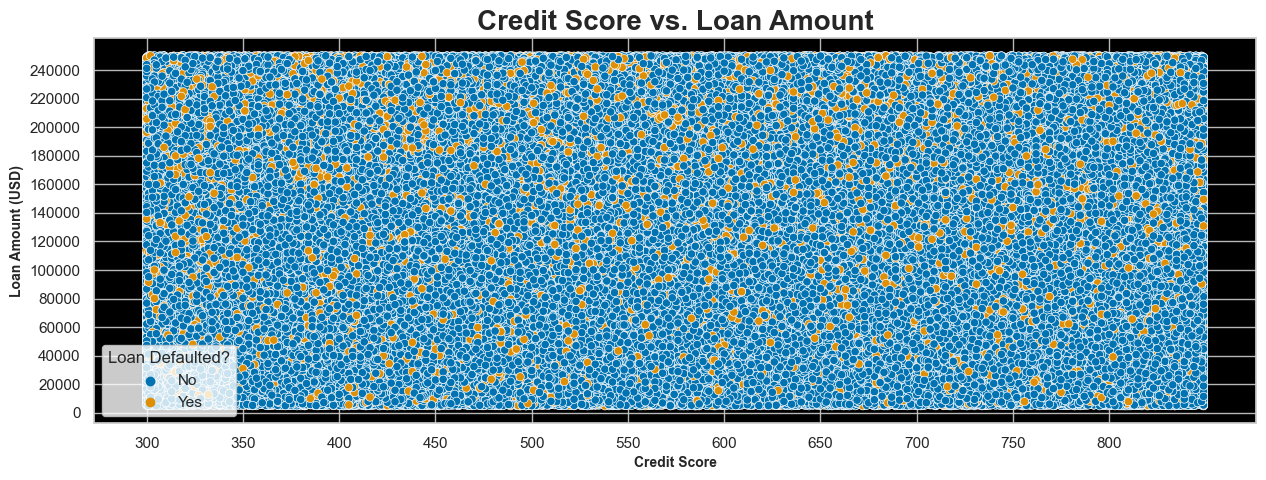

In [39]:
# plotting the incomes against their associated loan amounts
plt.figure(figsize = (15, 5))
ax = sns.scatterplot(data = df, x = 'CreditScore', y = 'LoanAmount', hue = 'Default_word_ver', palette='colorblind')
plt.legend(loc = 'lower left', title = 'Loan Defaulted?')
plt.xlabel('Credit Score', weight = 'bold', size = 10)
plt.ylabel('Loan Amount (USD)', weight = 'bold', size = 10)
plt.title('Credit Score vs. Loan Amount', weight = 'bold', size = 20)
plt.yticks(list(range(0,260000,20000)))
plt.xticks(list(range(300,850,50)))
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()

There appears to be even less correlation between credit score and loan amount, as well as little relationship as to
whether a loan defaulted. This suggests that neither income level, credit score, nor size of the loan independently serve as 
good predictors of whether a loan defaults. To predict loan defaults accurately seems to require a combination of multiple factors.


We are now prepared to move onto modeling the data and making predictions.

<a name="header-2"></a>
## Modeling the Data

This section covers the preprocessing, modeling, and tuning of multiple supervised machine learning models for predicting
whether a given loan defaults. The models tested here include:
* Logistic Regression
* Decision Trees
* Random Forest
* Naive Bayes
* XGBoost
* K-nearest Neighbors (*current excluded due to unknown error; to be fixed in version 2*)

Since 88.39% of the loans did not default, we have a **baseline accuracy** of 0.8839. As will be discussed in the concluding sections, accuracy is not necessarily the most important metrics here. From a consumer point-of-view, having high precision is likely also important since it would minimize the number of people who are rejected for a loan because the model falsely predicts that they would default on the loan. Similarly, a business may be more concerned with recall because a high false negative rate would result in a greater number of loans being given to people who are more likely to default. 

As I will elaborate on later, **F1** and **ROC-AUC** (*area under the receiver operating characteristic*) scores offer the best measurement of a model's performance since they represent a more balanced level of concern with both precision and recall. That said, the final models--**XGBoost** and **Random Forest**--both yield high values across all metrics so this does not turn out to be a serious concern. 

### Preprocessing the Data

As mentioned earlier, the categorical columns need to be encoded as numbers so that they can be incorporated into the models. I have chosen a mix of label encoding and one-hot encoding to accomplish this.

**Label Encoding**
* Education
* EmploymentType
* MaritalStatus
* LoanPurpose

**One-hot Encoding**
* HasMortgage
* HasDependents
* HasCoSigner

In [17]:
# label encoding
label_encoder = LabelEncoder()
df['Education_encoded'] = label_encoder.fit_transform(df['Education'])
df['EmploymentType_encoded'] = label_encoder.fit_transform(df['EmploymentType'])
df['MartialStatus_encoded'] = label_encoder.fit_transform(df['MaritalStatus'])
df['LoanPurpose_encoded'] = label_encoder.fit_transform(df['LoanPurpose'])

# one-hot encoding
df_encoded = pd.get_dummies(df, columns = ['HasMortgage', 'HasDependents', 'HasCoSigner'])

There are now several columns that have duplicate information. These will be dropped.

In [18]:
# dropping unneeded columns
df_encoded.drop(columns=['LoanID', 'LoanPurpose', 'Education',
                               'EmploymentType',  'MaritalStatus', 'IncLoanDiff_bins',
                               'IncLoanPer_bins', 'Default_word_ver'], 
                inplace=True)

# changing all datatypes to float64 (this is needed for KNN)
df_encoded = df_encoded.astype(float)

In [19]:
# making the feature table and the prediction column
X = df_encoded.drop(columns = ['Default'])
y = df_encoded.Default

### Base Models (unadjusted data)

To create base-level scores for all of the classification metrics--**accuracy**, **recall**, **precision**, **F1**, **ROC_AUC**--I will now construct base versions of each model based on this raw dataset. Importantly, the dataset has not 
yet been adjusted to account for the imbalance in the classes for the prediction nor has the data been rescaled to be uniform across all features. As will be shown
later, making both of these adjustments improves model performance significantly.

In [20]:
# making a table to track the performance of the models
metrics = {'Model': [],
           'Accuracy': [],
           'Precision': [],
           'Recall': [],
           'F1-Score': [],
           'ROC_AUC': []}

In [21]:
# splitting the datasets into train-validation-testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8413)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 8413)

# setting up the models 
models = {
    "Logistic Regression": LogisticRegression(max_iter = 10000),
    "Naive Bayes": GaussianNB(),
    #"KNN": KNeighborsClassifier(),  
    "Decision Tree": DecisionTreeClassifier(random_state = 8413),
    "Random Forest": RandomForestClassifier(random_state = 8413),
    "XGBoost": XGBClassifier(random_state = 8413)
}

# cross-validating the models
for model_name, model in models.items():
    accuracies = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
    precisions = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'precision')
    recalls = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'recall')
    f1_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'f1')
    roc_auc_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'roc_auc')
    
    # Adding results to the metrics dictionary
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(np.mean(accuracies))
    metrics['Precision'].append(np.mean(precisions))
    metrics['Recall'].append(np.mean(recalls))
    metrics['F1-Score'].append(np.mean(f1_scores))
    metrics['ROC_AUC'].append(np.mean(roc_auc_scores))

In [22]:
# Making the metrics dictionary into a dataframe and displaying the table
model_base_scores_df = pd.DataFrame(metrics)
model_base_scores_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC_AUC
0,Logistic Regression,0.885523,0.602843,0.045165,0.083982,0.727925
1,Naive Bayes,0.859577,0.327618,0.197768,0.246631,0.714906
2,Decision Tree,0.802914,0.198916,0.229720,0.213211,0.554015
3,Random Forest,0.885437,0.589941,0.048008,0.088779,0.728672
4,XGBoost,0.883773,0.500337,0.085961,0.146707,0.733173


While the accuracy of many of the models appears reasonably strong initially, we have to keep in mind that just guessing the 
majority class--that a given loan does not default--will be correct 88.39% of the time. Given this context, the accuracies are either lower than the baseline or less than 0.2% better. There are also fairly low scores across all other metrics, meaning that the dataset must be more refined in order to produce a model that outperforms the baseline.

To achieve this, I will now scale the data to a uniform range and rebalance the predicted classes using SMOTE.

In [23]:
# rescaling the data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

# rebalancing the classes
smote = SMOTE(random_state=8413)
X_rebal, y_rebal = smote.fit_resample(X_scale, y)

# resplitting the data
X_train, X_test, y_train, y_test = train_test_split(X_rebal, y_rebal, test_size = 0.2, random_state = 8413)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 8413)

We can now redo the modeling process with the rescaled and rebalanced dataset.

In [24]:
### Making a dictionary to track all of the model scores
metrics_2 = {"Model": [],
          "Accuracy": [],
          "Precision": [],
          "Recall": [],
          "F1-Score": [],
          "ROC_AUC": []}

# remaking the models with scaled and balanced dataset
for model_name, model in models.items():
    accuracies = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
    precisions = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'precision')
    recalls = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'recall')
    f1_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'f1')
    roc_auc_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'roc_auc')
    
    # Adding results to the metrics dictionary
    metrics_2['Model'].append(model_name)
    metrics_2['Accuracy'].append(np.mean(accuracies))
    metrics_2['Precision'].append(np.mean(precisions))
    metrics_2['Recall'].append(np.mean(recalls))
    metrics_2['F1-Score'].append(np.mean(f1_scores))
    metrics_2['ROC_AUC'].append(np.mean(roc_auc_scores))

In [25]:
### Changing the metrics dictionary into a dataframe for viewing
model_2_scores_df = pd.DataFrame(metrics_2)
model_2_scores_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC_AUC
0,Logistic Regression,0.697786,0.696302,0.702265,0.699270,0.766893
1,Naive Bayes,0.672032,0.709873,0.582601,0.639970,0.748045
2,Decision Tree,0.825531,0.817327,0.838762,0.827902,0.825522
3,Random Forest,0.921333,0.940945,0.899210,0.919602,0.973924
4,XGBoost,0.929284,0.986836,0.870269,0.924894,0.964833


By rebalancing and rescaling the data, we have seen a significant rise in performance for precision, recall, F1, and ROC_AUC. While accuracy has decreased for the first three models--logistic regression, naive bayes, and decision tree--the last two--random forest and xgboost--have seen their accuracies rise by approximately 3.4%. As such, I will now further tune the latter two to find the best performing model.

To do this, I will use a grid search to determine the brest hyperparameters for each model.

In [26]:
# Making a dictionary to track the tuned model performances
tuned_model_dict = {
    'Model Type': [],
    'Metric': [],
    'Score': []
}

I will optimize for accuracy since it is the most readable metric overall. That said, my choice not to rerun the grid search to optimize for other metrics is based on personal computational limitations (the runtime is too long) and is not an indication of such a step's unimportance. Given different circumstances, it might be well worth it to look to optimize for other metrics.

The first gridsearch is for the XGBoost model.

In [27]:
### Making the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

### Re-instantiating the model
xgb_tuned_model = XGBClassifier(objective='binary:logistic',
                          random_state = 8413)

### Performing the grid search
xgb_grid_search = GridSearchCV(
    xgb_tuned_model,
    param_grid, 
    cv = 5,
    scoring = 'accuracy',
    verbose = 1
)

### fitting the model
xgb_grid_search.fit(X_train, y_train)

### Checking the results of the grid search
best_tuned_xgb_model = xgb_grid_search.best_estimator_
best_xgb_acc_params = xgb_grid_search.best_params_
best_xgb_acc_score = xgb_grid_search.best_score_

### Adding the information to the table
tuned_model_dict['Model Type'].append('XGBoost')
tuned_model_dict['Metric'].append('Accuracy')
tuned_model_dict['Score'].append(best_xgb_acc_score)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


Now for the random forest model. Note that I am using a small grid due to computational limitations.

In [29]:
### Making the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 2, 3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

### Re-instantiating the model
random_forest_tuned_model = RandomForestClassifier(random_state = 8413)

### Performing the grid search
random_forest_grid_search = GridSearchCV(
    random_forest_tuned_model,
    param_grid, 
    cv = 5,
    scoring = 'accuracy',
    verbose = 1
)

### fitting the model
random_forest_grid_search.fit(X_train, y_train)

### Checking the results of the grid search
best_tuned_random_forest_model = random_forest_grid_search.best_estimator_
best_random_forest_acc_params = random_forest_grid_search.best_params_
best_random_forest_acc_score = random_forest_grid_search.best_score_

### Adding the information to the table
tuned_model_dict['Model Type'].append('Random Forest')
tuned_model_dict['Metric'].append('Accuracy')
tuned_model_dict['Score'].append(best_random_forest_acc_score)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


#### Comparison Table for XGBoost and Random Forest Models

In [30]:
### Showing the table
pd.DataFrame(tuned_model_dict)

,Model Type,Metric,Score
0,XGBoost,Accuracy,0.929997
1,Random Forest,Accuracy,0.929630


Refining the data has raised the accuracy of the random forest model by approximately 0.8% while the xgboost model has stayed approximately the same. Given that the two models are separated in accuracy by only about 0.033%, deciding which model is better will depend on how each model performs on other metrics.

We can now move on to create the final versions of these two models and determine which is superior.

### Creating the Final Models

#### XGBoost

In [31]:
### Looking at the best parameters
best_xgb_acc_params

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 400,
 'subsample': 1}

In [32]:
# instantiating the model with optimized hyperparameters
final_xgb_model = XGBClassifier(
    n_estimators = 400, 
    max_depth = 5, 
    learning_rate = 0.1,
    subsample = 1,
    colsample_bytree = 1,
    random_state = 8413
)

# fitting the model
final_xgb_model.fit(X_train, y_train)

# making predictions based on validation set
y_val_pred = final_xgb_model.predict(X_val)

# obtaining the metric scores based on validation set
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_rec = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred)

# same thing but for test set
y_test_pred = final_xgb_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)

#### Random Forest

In [33]:
### Looking at the best parameters
best_random_forest_acc_params

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [34]:
# instantiating the model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    random_state=8413
)

# fitting the model
rf_model.fit(X_train, y_train)

# making predictions based on validation set
y_val_pred = rf_model.predict(X_val)

# determining metrics based on validation set
val_rf_acc = accuracy_score(y_val, y_val_pred)
val_rf_prec = precision_score(y_val, y_val_pred)
val_rf_rec = recall_score(y_val, y_val_pred)
val_rf_f1 = f1_score(y_val, y_val_pred)
val_rf_roc_auc = roc_auc_score(y_val, y_val_pred)

# same thing but for test set
y_test_pred = rf_model.predict(X_test)
test_rf_acc = accuracy_score(y_test, y_test_pred)
test_rf_prec = precision_score(y_test, y_test_pred)
test_rf_rec = recall_score(y_test, y_test_pred)
test_rf_f1 = f1_score(y_test, y_test_pred)
test_rf_roc_auc = roc_auc_score(y_test, y_test_pred)

#### Results Table

In [35]:
### Making a table to store the final models' information
final_models_metrics_table = pd.DataFrame({
    'Model': ['XGBoost', 'XGBoost', 'Random Forest', 'Random Forest'],
    'Data Tested': ['Validation Set', 'Test Set', 'Validation Set', 'Test Set'],
    'Accuracy': [val_acc, test_acc, val_rf_acc, test_rf_acc],
    'Precision': [val_prec, test_prec, val_rf_prec, test_rf_prec],
    'Recall': [val_rec, test_rec, val_rf_rec, test_rf_rec],
    'F1': [val_f1, test_f1, val_rf_f1, test_rf_f1],
    'ROC_AUC': [val_roc_auc, test_roc_auc, val_rf_roc_auc, test_rf_roc_auc]
})

### Final models
final_models_metrics_table

,Model,Data Tested,Accuracy,Precision,Recall,F1,ROC_AUC
0,XGBoost,Validation Set,0.930077,0.989162,0.868942,0.925163,0.929760
1,XGBoost,Test Set,0.928720,0.990146,0.866359,0.924125,0.928850
2,Random Forest,Validation Set,0.937152,0.955951,0.915848,0.935470,0.937042
3,Random Forest,Test Set,0.935610,0.955407,0.914156,0.934326,0.935655


## Conclusion

Overall, the two models are very similar in performance, with the largest differences appearing with precision and recall.

* For **accuracy**, the models are very similar in performance but the random forest model is better by about 0.7%.
* For **precision**, the *xgboost model* is better by approximately 3.5%.
* For **recall**, the *random forest model* is better by approximately 4%.
* For **F1-Score**, the models are similar in performance but the random forest model is better by about 1%.
* For **ROC_AUC**, the models are very similar, being separated by only about 0.3%.

Which model is better really depends on whether you are more concerned with false positives or false negatives. 

From a lender's point-of-view, recall may be more important since inaccurately assessing a potential loan taker to 
be likely to be able to pay back the loan could lead to giving out loans that are likely to default. If this is the
primary concern, then the **random forest model** is better. That said, precision is also important. Lower precision would 
mean that more people who would likely be able to pay back the loan would be predicted to not be able to avoid defaulting and 
might therefore be rejected for a loan. If this is the dominant concern, then the **xgboost model** edges out the random 
forest model. 

Given that comparable performance in accuracy between the two models and the yet undetermined prioritization between precision
and recall, I recommend use of the **random forest model** over its competitor due to the higher F1-score. The aforementioned
reasons for caring about recall and precision are not mutually exclusive, and in practice, both are likely to be active 
concerns. Thus, by taking the F1-score as the primary decider, the random forest model emerges as the optimal model.



## Final Notes

### Future Work

This is the first version of this report. While its contents are meant to be robust, they are not comprehensive. There are
other classification models that could be tested and alternative tuning of the hyperparameters could be attempted. To the
latter point in particular, as I noted earlier, I optimized the models for accuracy. This may not be the ideal metric for 
optimization. Depending on the perspective of a user of the model, it may be advisable to instead directly optimize for 
precision or recall. I have not attempted to do so in this version due to computational limitations but may attempt to do
so in a later version. 

I also have not explored all of the features fully. In particular, the variable importance of each of the features has not
been considered in this version. If some of the features were shown to have little or no effect on the models' performances,
they could be excluded from the model training step and would therefore improve runtime.

### Credits and Disclaimers
**Author/Programmer:** Tyler Chang

**Data Source:** 
https://www.kaggle.com/datasets/nikhil1e9/loan-default

**Python Version Used:** 3.11.3

---

Like the vast majority of programming, the work here may resemble others' work. Where I am aware of this similarity,
I have tried to note it but I cannot offer a comprehensive list of all possibile similarities. Thus, while all of the code 
included here was authored by me, if you find similarities to your work, please let me know (see links at the top for contact information) and I am happy to provide proper acknowledgement of your work. 